zadanie-analiza danych-linkedin job postings

1. Load lib and files

https://www.kaggle.com/datasets/arshkon/linkedin-job-postings

In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time
import zipfile

In [2]:
from scipy.stats import normaltest
from scipy.stats import f_oneway
from scipy.stats import kruskal
from scipy.stats import chi2_contingency

In [ ]:
zip_path = 'C:/Users/mateg/OneDrive/Pulpit/zadanko-linkedin-job-postings/data.zip'

with zipfile.ZipFile(zip_path,'r') as zip_ref:
    zip_ref.extractall(os.path.dirname(zip))

In [3]:
path = 'C:/Users/mateg/OneDrive/Pulpit/zadanko-linkedin-job-postings/data'
notebook_start_time = time.time()

In [4]:
## Dataset folder structure
for file in os.listdir(path):
    file_path = os.path.join(path, file)
    if os.path.isdir(file_path):
        print(f"{file}/")
        for nestfile in os.listdir(file_path):
            print(f"  {nestfile}")
    else:
        print(file)

company_details/
  companies.csv
  company_industries.csv
  company_specialities.csv
  employee_counts.csv
job_details/
  benefits.csv
  job_industries.csv
  job_skills.csv
  salaries.csv
job_postings.csv
maps/
  industries.csv
  skills.csv


In [5]:
job_postings_original = pd.read_csv(f'{path}/job_postings.csv', sep=',')
job_postings_df = pd.DataFrame(job_postings_original)

In [6]:
##additional info: companies_details, job_details, industries, skills -- if needed
# job_postings_original = pd.read_csv(f'{path}/company_details/companies.csv', sep=',')
# job_postings_original = pd.read_csv(f'{path}/company_details/company_industries.csv', sep=',')
# job_postings_original = pd.read_csv(f'{path}/company_details/company_specialities.csv', sep=',')
# job_postings_original = pd.read_csv(f'{path}/company_details/employee_counts.csv', sep=',')
# job_postings_original = pd.read_csv(f'{path}/job_details/benefits.csv', sep=',')
# job_postings_original = pd.read_csv(f'{path}/job_details/job_industries.csv', sep=',')
# job_postings_original = pd.read_csv(f'{path}/job_details/job_skills.csv', sep=',')
# job_postings_original = pd.read_csv(f'{path}/job_details/sallaries.csv', sep=',')
# job_postings_original = pd.read_csv(f'{path}/maps/industries.csv', sep=',')
# job_postings_original = pd.read_csv(f'{path}/maps/skills.csv', sep=',')

-------------------------------------------------------------------------------------------------------------------------

2. Quick Overview

In [7]:
job_postings_df.head(2)

,job_id,company_id,title,description,max_salary,med_salary,min_salary,pay_period,formatted_work_type,location,...,closed_time,formatted_experience_level,skills_desc,listed_time,posting_domain,sponsored,work_type,currency,compensation_type,scraped
0,3757940104,553718.0,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.0,NaN,MONTHLY,Full-time,"Little River, SC",...,NaN,Entry level,NaN,1.699090e+12,careers-demant.icims.com,0,FULL_TIME,USD,BASE_SALARY,1699138101
1,3757940025,2192142.0,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",...,NaN,NaN,NaN,1.699080e+12,www.click2apply.net,0,FULL_TIME,NaN,NaN,1699085420


In [8]:
#general info
print(job_postings_df.columns)
print("")
print(f"Number of rows (observations) and columns (attributes): {job_postings_df.shape}")
print("")
print(job_postings_df.dtypes)

Index(['job_id', 'company_id', 'title', 'description', 'max_salary',
       'med_salary', 'min_salary', 'pay_period', 'formatted_work_type',
       'location', 'applies', 'original_listed_time', 'remote_allowed',
       'views', 'job_posting_url', 'application_url', 'application_type',
       'expiry', 'closed_time', 'formatted_experience_level', 'skills_desc',
       'listed_time', 'posting_domain', 'sponsored', 'work_type', 'currency',
       'compensation_type', 'scraped'],
      dtype='object')

Number of rows (observations) and columns (attributes): (33246, 28)

job_id                          int64
company_id                    float64
title                          object
description                    object
max_salary                    float64
med_salary                    float64
min_salary                    float64
pay_period                     object
formatted_work_type            object
location                       object
applies                       float64
original

-------------------------------------------------------------------------------------------------------------------------

3. Cleaning Data (NaN, formats and Outliers) and preliminary analysis

In [9]:
##change to date type: original_listed_time, closed time, listed_time
job_postings_df['closed_time'] = pd.to_datetime(job_postings_df['closed_time'], unit='ms')
job_postings_df['original_listed_time'] = pd.to_datetime(job_postings_df['original_listed_time'], unit='ms')
job_postings_df['listed_time'] = pd.to_datetime(job_postings_df['listed_time'], unit='ms')
job_postings_df['expiry'] = pd.to_datetime(job_postings_df['expiry'],unit='ms')

job_postings_df.drop('work_type',inplace=True, axis=1)

job_id                            0
company_id                      654
title                             0
description                       1
max_salary                    22135
med_salary                    31005
min_salary                    22135
pay_period                    19894
formatted_work_type               0
location                          0
applies                       17008
original_listed_time              0
remote_allowed                28444
views                          7360
job_posting_url                   0
application_url               12250
application_type                  0
expiry                            0
closed_time                   32074
formatted_experience_level     9181
skills_desc                   32909
listed_time                       0
posting_domain                13558
sponsored                         0
currency                      19894
compensation_type             19894
scraped                           0
dtype: int64


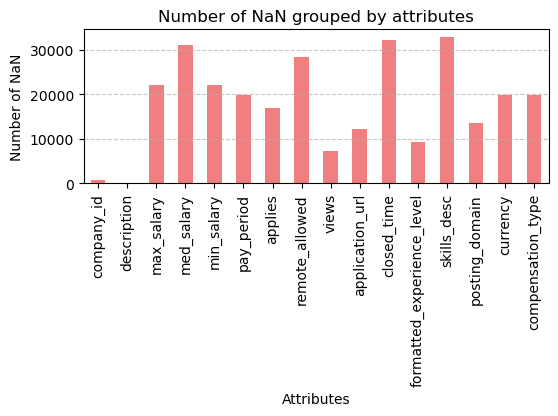

In [10]:
#Are there missing values | How many? | Formatting Errors?
print(job_postings_df.isnull().sum())

na_counts = job_postings_df.isnull().sum()
na_counts_filtered = na_counts[na_counts > 0]

#plot bar chart
plt.figure(figsize=(6,2))
na_counts_filtered.plot(kind='bar', color='lightcoral')
plt.title('Number of NaN grouped by attributes')
plt.xlabel('Attributes')
plt.ylabel('Number of NaN')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [11]:
##Handle NaN

job_postings_df = job_postings_df.dropna(subset=['description'])
job_postings_df['closed_time'].fillna('open', inplace=True) ## assumption
job_postings_df['remote_allowed'].fillna('not specified', inplace=True) ## assumption
job_postings_df['formatted_experience_level'].fillna('not specified', inplace=True) ## assumption
job_postings_df['applies'].fillna(0, inplace=True) ## assumption becouse (job_postings_df['applies']==0).any() is False
job_postings_df['views'].fillna(0, inplace=True) ## assumption becouse (job_postings_df['views']==0).any() is False
job_postings_df['company_id'].fillna(0, inplace=True) ## 0 indicates no information for company id

columns_to_drop = ['pay_period','currency', 'skills_desc', 'posting_domain', 'scraped', 'compensation_type', 'application_url', 'job_posting_url']
job_postings_df.drop(columns=columns_to_drop, inplace=True, axis=1)


# job_postings_df = job_postings_df.drop_duplicates() ##duplicates

C:\Users\mateg\AppData\Local\Temp\ipykernel_1724\3191342880.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  job_postings_df['closed_time'].fillna('open', inplace=True) ## assumption
C:\Users\mateg\AppData\Local\Temp\ipykernel_1724\3191342880.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'open' has dtype incompatible with datetime64[ns], please explicitly cast to a compatible dtype first.
  job_postings_df['closed_time'].fillna('open', i

job_id                            0
company_id                        0
title                             0
description                       0
max_salary                    22134
med_salary                    31004
min_salary                    22134
formatted_work_type               0
location                          0
applies                           0
original_listed_time              0
remote_allowed                    0
views                             0
application_type                  0
expiry                            0
closed_time                       0
formatted_experience_level        0
listed_time                       0
sponsored                         0
dtype: int64


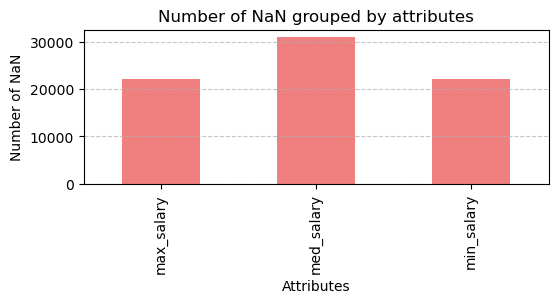

In [12]:
#Are there missing values | How many? | Formatting Errors?
print(job_postings_df.isnull().sum())
na_counts = job_postings_df.isnull().sum()
na_counts_filtered = na_counts[na_counts > 0]

#plot bar chart
plt.figure(figsize=(6, 2))
na_counts_filtered.plot(kind='bar', color='lightcoral')
plt.title('Number of NaN grouped by attributes')
plt.xlabel('Attributes')
plt.ylabel('Number of NaN')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [13]:
##Format changes - change to integer selected attributes
job_postings_df['company_id']=job_postings_df['company_id'].astype(int)
job_postings_df['applies']=job_postings_df['applies'].astype(int)
job_postings_df['views']=job_postings_df['views'].astype(int)

##Format changes - boolean or 0 1 attributes: remote_allowed, sponsored???
job_postings_df['sponsored'] = job_postings_df['sponsored'].astype(bool)

Number of outliers in max_salary: 41
Number of outliers in med_salary: 17
Number of outliers in min_salary: 28
Number of outliers in applies: 316
Number of outliers in views: 336


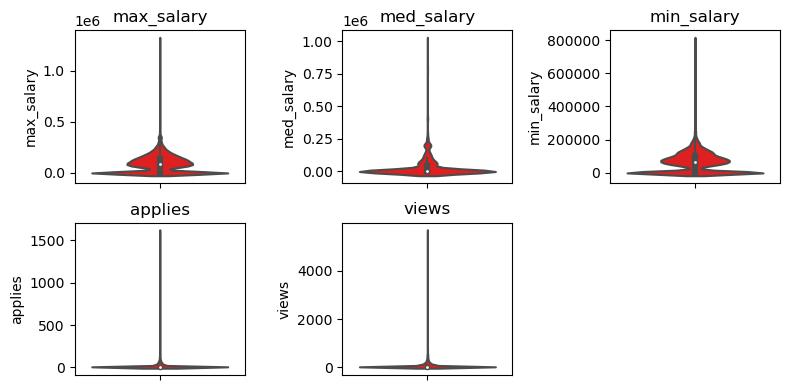

In [14]:
##Are there outliers? | How many?
selected_col = ['max_salary','med_salary','min_salary', 'applies', 'views']

def detect_outliers(df):
    threshold  = 4
    z_score = np.abs((df - df.mean())/df.std())
    return z_score > threshold

for col in selected_col:
    outliers = detect_outliers(job_postings_df[col])
    num_outliers = outliers.sum()
    print(f"Number of outliers in {col}: {num_outliers}")

##plot
plt.figure(figsize=(8,4))
for i, col in enumerate(selected_col, 1):
    plt.subplot(2,3,i)
    sns.violinplot(y=job_postings_df[col], color='red')
    plt.title(col)
plt.tight_layout()
plt.show()

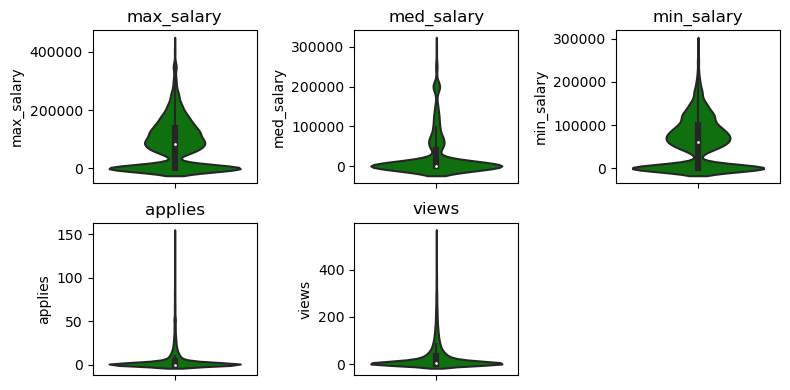

In [15]:
##Drop outliers | alternatively they can be transformed: scaled, normalized or replaced(Winsorization) or ignored
def handle_outliers(df, columns):
    drop_mask = np.zeros(len(df), dtype=bool)
    for col in columns:
        column_outliers = detect_outliers(df[col])
        drop_mask = drop_mask | column_outliers.values  # Combine with previous masks
    return df[~drop_mask]

job_postings_df = handle_outliers(job_postings_df, selected_col)


##plot
plt.figure(figsize=(8,4))
for i, col in enumerate(selected_col, 1):
    plt.subplot(2,3,i)
    sns.violinplot(y=job_postings_df[col], color='green')
    plt.title(col)
plt.tight_layout()
plt.show()

In [16]:
##postprocess dataframe -- #general info
print(job_postings_df.columns)
print("")
print(f"Number of rows (observations) and columns (attributes): {job_postings_df.shape}")
print("")
print(job_postings_df.dtypes)

Index(['job_id', 'company_id', 'title', 'description', 'max_salary',
       'med_salary', 'min_salary', 'formatted_work_type', 'location',
       'applies', 'original_listed_time', 'remote_allowed', 'views',
       'application_type', 'expiry', 'closed_time',
       'formatted_experience_level', 'listed_time', 'sponsored'],
      dtype='object')

Number of rows (observations) and columns (attributes): (32734, 19)

job_id                                 int64
company_id                             int32
title                                 object
description                           object
max_salary                           float64
med_salary                           float64
min_salary                           float64
formatted_work_type                   object
location                              object
applies                                int32
original_listed_time          datetime64[ns]
remote_allowed                        object
views                                  int

       max_salary  med_salary  min_salary   applies     views
count    10852.00     2210.00    10852.00  32734.00  32734.00
mean     86296.95    28059.24    61374.21      6.38     34.73
std      80973.42    56549.04    55830.11     16.26     68.07
min         10.00        0.00        7.25      0.00      0.00
25%         50.00       18.50       40.00      0.00      1.00
50%      82100.00       28.00    61103.00      0.00      7.00
75%     139425.00    40000.00    99102.00      4.00     35.00
max     425000.00   300000.00   286000.00    151.00    551.00


<Axes: >

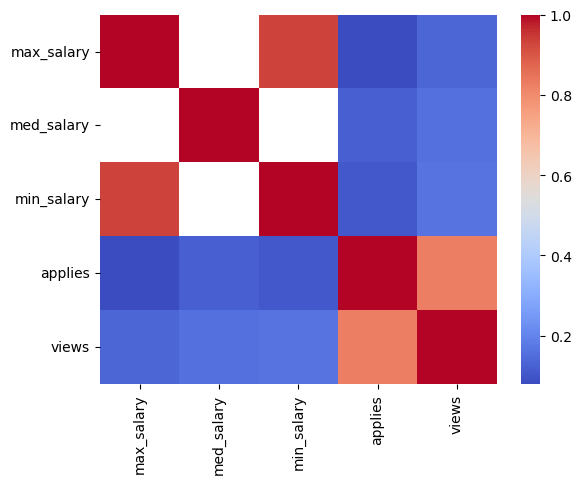

In [17]:
##Basic statistics for numerical cols
numerical_col = ['max_salary', 'med_salary', 'min_salary','applies', 'views']
print(job_postings_df[numerical_col].describe().round(2))

import seaborn as sns
sns.heatmap(job_postings_df[numerical_col].corr(), cmap='coolwarm')

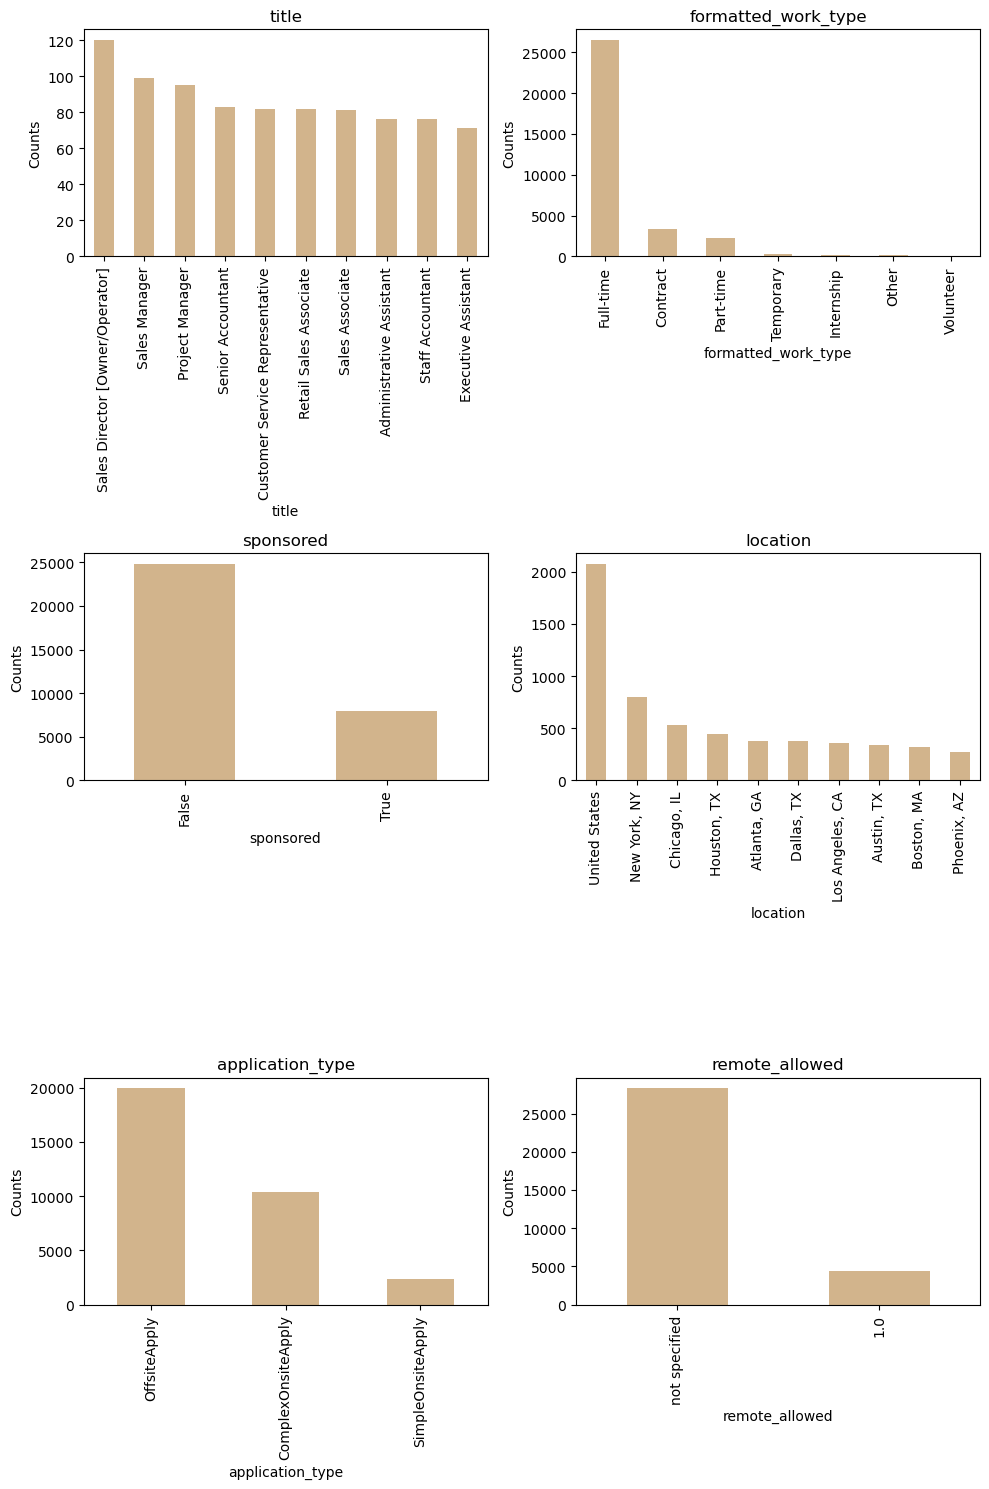

In [18]:
##Basic statistics for categorical cols
categorical_col = ['title','formatted_work_type','sponsored','location','application_type','remote_allowed']
n_rows = len(categorical_col) // 2 if len(categorical_col) % 2 == 0 else (len(categorical_col) // 2) + 1
plt.figure(figsize=(10, 5 * n_rows))

for i, col in enumerate(categorical_col, 1):
    value_counts = job_postings_df[col].value_counts().head(10)  # maximum for attribute is 10 

    plt.subplot(n_rows, 2, i)
    value_counts.plot(kind='bar', color='tan')
    plt.title(f'{col}')
    plt.xlabel(col)
    plt.ylabel('Counts')

plt.tight_layout()
plt.show()


-------------------------------------------------------------------------------------------------------------------------

Hypothesis 1: Job postings with positive emotional tone in their descriptions are associated with a higher number of applicant views or/and applications, compared to those with neutral or negative tones.

H0: There is no association between the emotional tone of job postings (positive, neutral, negative) and the number of applicant views or applications.

4. Text Preprocessing

In [19]:
text = job_postings_df['description']

In [20]:
import re
def preprocess_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) ##removeURL
    text = re.sub(r'\W+|\d+', ' ', text) ##remove special char, and numbers
    text = text.lower()
    text = re.sub(r'\s+', ' ', text).strip()
    return text

-------------------------------------------------------------------------------------------------------------------------

5. Sentiment Analysis (NLTK VADER, TextBlob, BERT)

In [21]:
##textBlob
from textblob import TextBlob

def anylyze_sentiment_textblob(text, threshold):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > threshold:
        sentiment = 'Positive'
    elif polarity < -(threshold):
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    return {'polarity_score': polarity, 'sentiment_category': sentiment}

start_time_textblob = time.time()
results = text.apply(lambda x: pd.Series({
    'preprocessed_text': preprocess_text(x),
    **anylyze_sentiment_textblob(preprocess_text(x), threshold=0.1)
}))
end_time_textblob = time.time()
time_method_analyze_sentiment_textblob = end_time_textblob - start_time_textblob
result_textblop_df = pd.DataFrame(results).reset_index(drop=True)
print(result_textblop_df.head(3))

                                   preprocessed_text  polarity_score  \
0  overview hearinglife is a national hearing car...        0.248791   
1  metalcraft of mayville metalcraft of mayville ...        0.048750   
2  the tsubaki name is synonymous with excellence...        0.104629   

  sentiment_category  
0           Positive  
1            Neutral  
2           Positive  


In [22]:
print((result_textblop_df['sentiment_category']=='Negative').value_counts())
print((result_textblop_df['sentiment_category']=='Neutral').value_counts())
print((result_textblop_df['sentiment_category']=='Positive').value_counts())

sentiment_category
False    32676
True        58
Name: count, dtype: int64
sentiment_category
False    27129
True      5605
Name: count, dtype: int64
sentiment_category
True     27071
False     5663
Name: count, dtype: int64


In [23]:
## nltk vader
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.download('vader_lexicon')

def analyze_sentiment_nltk(text, threshold):
    sid = SentimentIntensityAnalyzer()
    scores = sid.polarity_scores(text)
    polarity = scores['compound']
    if polarity > threshold:
        sentiment = 'Positive'
    elif polarity < -(threshold):
        sentiment = 'Negative'
    else:
        sentiment = 'Neutral'
    return {'polarity_score': polarity, 'sentiment_category': sentiment}

start_time_nltk = time.time()
results_nltk = text.apply(lambda x: pd.Series({
    'preprocessed_text': preprocess_text(x),
    **analyze_sentiment_nltk(preprocess_text(x),threshold=0.2)
}))
end_time_nltk = time.time()
time_method_analyze_sentiment_nltk = end_time_nltk - start_time_nltk
result_nltk_df = pd.DataFrame(results_nltk).reset_index(drop=True)
print(result_nltk_df.head(3))

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\mateg\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                   preprocessed_text  polarity_score  \
0  overview hearinglife is a national hearing car...          0.9997   
1  metalcraft of mayville metalcraft of mayville ...          0.9779   
2  the tsubaki name is synonymous with excellence...          0.9944   

  sentiment_category  
0           Positive  
1           Positive  
2           Positive  


In [24]:
print((result_nltk_df['sentiment_category']=='Negative').value_counts())
print((result_nltk_df['sentiment_category']=='Neutral').value_counts())
print((result_nltk_df['sentiment_category']=='Positive').value_counts())

sentiment_category
False    32605
True       129
Name: count, dtype: int64
sentiment_category
False    32477
True       257
Name: count, dtype: int64
sentiment_category
True     32348
False      386
Name: count, dtype: int64


In [25]:
# ## merge sentiment data frame to job_posting data frame
job_postings_df.reset_index(drop=True, inplace=True)
result_textblop_df.reset_index(drop=True, inplace=True)
result_nltk_df.reset_index(drop=True, inplace=True)
job_postings_df['polarity_score_textblob'] = result_textblop_df['polarity_score']
job_postings_df['sentiment_category_textblob'] = result_textblop_df['sentiment_category']
job_postings_df['polarity_score_nltk'] = result_nltk_df['polarity_score']
job_postings_df['sentiment_category_nltk'] = result_nltk_df['sentiment_category']


In [26]:
job_postings_df.head(2)

,job_id,company_id,title,description,max_salary,med_salary,min_salary,formatted_work_type,location,applies,...,application_type,expiry,closed_time,formatted_experience_level,listed_time,sponsored,polarity_score_textblob,sentiment_category_textblob,polarity_score_nltk,sentiment_category_nltk
0,3757940104,553718,Hearing Care Provider,Overview\n\nHearingLife is a national hearing ...,NaN,5250.0,NaN,Full-time,"Little River, SC",0,...,OffsiteApply,2023-12-04 08:53:20,open,Entry level,2023-11-04 09:26:40,False,0.248791,Positive,0.9997,Positive
1,3757940025,2192142,Shipping & Receiving Associate 2nd shift (Beav...,Metalcraft of Mayville\nMetalcraft of Mayville...,NaN,NaN,NaN,Full-time,"Beaver Dam, WI",0,...,OffsiteApply,2023-12-04 08:53:20,open,not specified,2023-11-04 06:40:00,False,0.048750,Neutral,0.9779,Positive


In [27]:
print(len(job_postings_df))
job_postings_df = job_postings_df[(job_postings_df['views'] > 0) & (job_postings_df['applies'] > 0)]
print(len(job_postings_df))

32734
15788


In [28]:
##applies to views ratio
job_postings_df['applies_to_views_ratio'] = job_postings_df['applies'] / job_postings_df['views']

In [29]:
print(sum(job_postings_df['views']))
print(sum(job_postings_df['applies']))
print(job_postings_df['applies'].value_counts().head(3))
print(job_postings_df['views'].value_counts().head(3))
print(job_postings_df['applies'].value_counts().tail(3))
print(job_postings_df['views'].value_counts().tail(3))

1004661
208868
applies
1    3702
2    1949
3    1261
Name: count, dtype: int64
views
3    363
5    348
6    344
Name: count, dtype: int64
applies
148    1
151    1
130    1
Name: count, dtype: int64
views
422    1
505    1
430    1
Name: count, dtype: int64


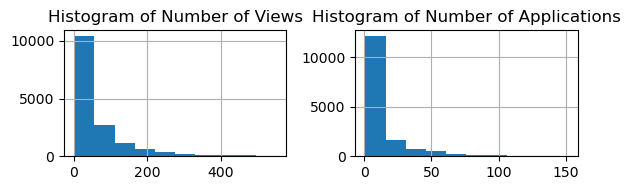

D'Agostino's K-squared Test: Statistics=8475.813, p=0.000
D'Agostino's K-squared Test: Statistics=9946.669, p=0.000


In [30]:
## check wheter it is normally distributed -- it is not
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 2))  # 1 row, 2 columns
job_postings_df['views'].hist(bins=10, ax=ax1)
ax1.set_title('Histogram of Number of Views')
job_postings_df['applies'].hist(bins=10, ax=ax2)
ax2.set_title('Histogram of Number of Applications')
plt.tight_layout()
plt.show()

stat, p = normaltest(job_postings_df['views'])
print("D'Agostino's K-squared Test: Statistics=%.3f, p=%.3f" % (stat, p))
stat, p = normaltest(job_postings_df['applies'])
print("D'Agostino's K-squared Test: Statistics=%.3f, p=%.3f" % (stat, p))

In [31]:
sentiment_analysis_results_textblob = job_postings_df.groupby('sentiment_category_textblob').agg(
    average_views=('views', 'mean'),
    average_applications=('applies', 'mean')
).reset_index()
print("");print(sentiment_analysis_results_textblob)

sentiment_analysis_results_textblob_ratio = job_postings_df.groupby('sentiment_category_textblob').agg(
    avg_applies_to_views_ratio=('applies_to_views_ratio', 'mean'),
).reset_index()
print("");print(sentiment_analysis_results_textblob_ratio)

sentiment_analysis_results_nltk = job_postings_df.groupby('sentiment_category_nltk').agg(
    average_views=('views', 'mean'),
    average_applications=('applies', 'mean')
).reset_index()
print("");print(sentiment_analysis_results_nltk)

sentiment_analysis_results_nltk_ratio = job_postings_df.groupby('sentiment_category_nltk').agg(
    avg_applies_to_views_ratio=('applies_to_views_ratio', 'mean'),
).reset_index()
print("");print(sentiment_analysis_results_nltk_ratio)



  sentiment_category_textblob  average_views  average_applications
0                    Negative      64.344828             16.655172
1                     Neutral      61.769443             12.888851
2                    Positive      64.054540             13.298841

  sentiment_category_textblob  avg_applies_to_views_ratio
0                    Negative                    0.238135
1                     Neutral                    0.209302
2                    Positive                    0.223230

  sentiment_category_nltk  average_views  average_applications
0                Negative      62.857143             13.142857
1                 Neutral      64.271318             16.224806
2                Positive      63.631994             13.205089

  sentiment_category_nltk  avg_applies_to_views_ratio
0                Negative                    0.218481
1                 Neutral                    0.241679
2                Positive                    0.220528


-------------------------------------------------------------------------------------------------------------------------

6. Testing Hypothesis and evaluation

In [32]:
def testing_hypothesis(job_postings_df, method):
    results={}
    print("");print('ANOVA Test')
    #ANOVA Test -- views
    fvalue_a_v, pvalue_a_v = f_oneway(
        job_postings_df[job_postings_df[method] == 'Positive']['views'],
        job_postings_df[job_postings_df[method] == 'Neutral']['views'],
        job_postings_df[job_postings_df[method] == 'Negative']['views']
    )
    print('ANOVA views: F-value=%.3f, P-value=%.3f' % (fvalue_a_v, pvalue_a_v))
    results['ANOVA_views'] = {'F-value': fvalue_a_v, 'P-value': pvalue_a_v}
    #ANOVA Test -- applies
    fvalue_a_a, pvalue_a_a = f_oneway(
        job_postings_df[job_postings_df[method] == 'Positive']['applies'],
        job_postings_df[job_postings_df[method] == 'Neutral']['applies'],
        job_postings_df[job_postings_df[method] == 'Negative']['applies']
    )
    print('ANOVA applies: F-value=%.3f, P-value=%.3f' % (fvalue_a_a, pvalue_a_a ))
    results['ANOVA_applies'] = {'F-value': fvalue_a_a, 'P-value': pvalue_a_a}
    # ANOVA Test - ratio applies to views
    fvalue_a_r, pvalue_a_r = f_oneway(
        job_postings_df[job_postings_df[method] == 'Positive']['applies_to_views_ratio'],
        job_postings_df[job_postings_df[method] == 'Neutral']['applies_to_views_ratio'],
        job_postings_df[job_postings_df[method] == 'Negative']['applies_to_views_ratio']
    )
    print('ANOVA ratio applies to view: F-value=%.3f, P-value=%.3f' % (fvalue_a_r, pvalue_a_r ))
    results['ANOVA_ratio'] = {'F-value': fvalue_a_r, 'P-value': pvalue_a_r}


    print("");print('Kruskal-Wallis Test')
    # Kruskal-Wallis Test -- views
    stat_k_w_v, p_k_w_v = kruskal(
        job_postings_df[job_postings_df[method] == 'Positive']['views'],
        job_postings_df[job_postings_df[method] == 'Neutral']['views'],
        job_postings_df[job_postings_df[method] == 'Negative']['views']
    )
    print('Kruskal-Wallis Test: views Statistics=%.3f, p=%.3f' % (stat_k_w_v, p_k_w_v))
    results['Kruskal_Wallis_views'] = {'Statistics': stat_k_w_v, 'P-value': p_k_w_v}
    # Kruskal-Wallis Test -- applies
    stat_k_w_a, p_k_w_a = kruskal(
        job_postings_df[job_postings_df[method] == 'Positive']['applies'],
        job_postings_df[job_postings_df[method] == 'Neutral']['applies'],
        job_postings_df[job_postings_df[method] == 'Negative']['applies']
    )
    print('Kruskal-Wallis Test: applies Statistics=%.3f, p=%.3f' % (stat_k_w_a, p_k_w_a))
    results['Kruskal_Wallis_applies'] = {'Statistics': stat_k_w_a, 'P-value': p_k_w_a}
    # Kruskal-Wallis Test -- for applies to view ratio
    stat_k_w_r, p_k_w_r = kruskal(
        job_postings_df[job_postings_df[method] == 'Positive']['applies_to_views_ratio'],
        job_postings_df[job_postings_df[method] == 'Neutral']['applies_to_views_ratio'],
        job_postings_df[job_postings_df[method] == 'Negative']['applies_to_views_ratio']
    )
    print('Kruskal-Wallis Test: ratio applies to view Statistics=%.3f, p=%.3f' % (stat_k_w_r, p_k_w_r))
    results['Kruskal_Wallis_ratio'] = {'Statistics': stat_k_w_r, 'P-value': p_k_w_r}


    print("");print('Chi-test')
    #chi-test -- views
    job_postings_df['views_category'] = pd.qcut(job_postings_df['views'], 3, labels=['Low', 'Medium', 'High'])
    contingency_views = pd.crosstab(job_postings_df[method], job_postings_df['views_category'])
    chi2_views, p_views, dof_views, expected_views = chi2_contingency(contingency_views)
    print('Chi2 Statistic in views: Statistics=%.3f, P-value=%.3f' % (chi2_views, p_views))
    results['Chi_Square_views'] = {'Chi2 Statistic': chi2_views, 'P-value': p_views}
    #chi-test -- applies
    job_postings_df['applies_category'] = pd.qcut(job_postings_df['applies'], 3, labels=['Low', 'Medium', 'High'])
    contingency_applications = pd.crosstab(job_postings_df[method], job_postings_df['applies'])
    chi2_applications, p_applies, dof_applications, expected_applications = chi2_contingency(contingency_applications)
    print('Chi2 Statistic in applies: Statistics=%.3f, P-value=%.3f' % (chi2_applications, p_applies))
    results['Chi_Square_applies'] = {'Chi2 Statistic': chi2_applications, 'P-value': p_applies}
    #chi-test -- for applies to view ratio
    job_postings_df['applies_to_views_ratio_category'] = pd.qcut(job_postings_df['applies_to_views_ratio'], 3, labels=['Low', 'Medium', 'High'])
    contingency_ratio = pd.crosstab(job_postings_df[method], job_postings_df['applies_to_views_ratio_category'])
    chi2_ratio, p_ratio,_,_ = chi2_contingency(contingency_ratio)
    print('Chi2 Statistic ratio applies to view: Statistics=%.3f, P-value=%.3f' % (chi2_ratio, p_ratio))
    results['Chi_Square_ratio'] = {'Chi2 Statistic': chi2_ratio, 'P-value': p_ratio}

    return results

In [33]:
##---------------------------------------------------TESTING FOR TEXTBLOB---------------------------------------------------
results_textblob = testing_hypothesis(job_postings_df=job_postings_df, method='sentiment_category_textblob')


ANOVA Test
ANOVA views: F-value=0.900, P-value=0.407
ANOVA applies: F-value=0.808, P-value=0.446
ANOVA ratio applies to view: F-value=8.038, P-value=0.000

Kruskal-Wallis Test
Kruskal-Wallis Test: views Statistics=0.830, p=0.660
Kruskal-Wallis Test: applies Statistics=1.815, p=0.404
Kruskal-Wallis Test: ratio applies to view Statistics=6.008, p=0.050

Chi-test
Chi2 Statistic in views: Statistics=7.698, P-value=0.103
Chi2 Statistic in applies: Statistics=748.416, P-value=0.000
Chi2 Statistic ratio applies to view: Statistics=7.047, P-value=0.133


In [34]:
##---------------------------------------------------TESTING FOR NLTK VADER---------------------------------------------------
results_nltk = testing_hypothesis(job_postings_df=job_postings_df, method='sentiment_category_nltk')


ANOVA Test
ANOVA views: F-value=0.006, P-value=0.994
ANOVA applies: F-value=1.275, P-value=0.279
ANOVA ratio applies to view: F-value=0.986, P-value=0.373

Kruskal-Wallis Test
Kruskal-Wallis Test: views Statistics=0.983, p=0.612
Kruskal-Wallis Test: applies Statistics=2.548, p=0.280
Kruskal-Wallis Test: ratio applies to view Statistics=2.771, p=0.250

Chi-test
Chi2 Statistic in views: Statistics=0.897, P-value=0.925
Chi2 Statistic in applies: Statistics=288.739, P-value=0.639
Chi2 Statistic ratio applies to view: Statistics=3.704, P-value=0.448


-------------------------------------------------------------------------------------------------------------------------

7. Presentation of results (table and vizualization)

In [35]:
##table of results: ##col: name | p-values | potential association with emotional tone (yes/no/dk) ##Rows: result measures concatenated
def evaluate_p_value(p):
    if p < 0.05:
        return 'Yes'
    elif p > 0.05:
        return 'No'
    else:
        return 'DK'
    
data = []
for method, results in {'TextBlob': results_textblob, 'NLTK': results_nltk}.items():
    for test_name, test_results in results.items():
        data.append({
            'Method': method,
            'Test': test_name,
            'P-value': test_results['P-value'],
            'Potential Association': evaluate_p_value(test_results['P-value'])
        })
summarizing_result = pd.DataFrame(data)
print(summarizing_result)

      Method                    Test       P-value Potential Association
0   TextBlob             ANOVA_views  4.066679e-01                    No
1   TextBlob           ANOVA_applies  4.459067e-01                    No
2   TextBlob             ANOVA_ratio  3.241595e-04                   Yes
3   TextBlob    Kruskal_Wallis_views  6.603355e-01                    No
4   TextBlob  Kruskal_Wallis_applies  4.035592e-01                    No
5   TextBlob    Kruskal_Wallis_ratio  4.958077e-02                   Yes
6   TextBlob        Chi_Square_views  1.033024e-01                    No
7   TextBlob      Chi_Square_applies  1.300143e-40                   Yes
8   TextBlob        Chi_Square_ratio  1.334098e-01                    No
9       NLTK             ANOVA_views  9.937567e-01                    No
10      NLTK           ANOVA_applies  2.794443e-01                    No
11      NLTK             ANOVA_ratio  3.732230e-01                    No
12      NLTK    Kruskal_Wallis_views  6.116439e-01 

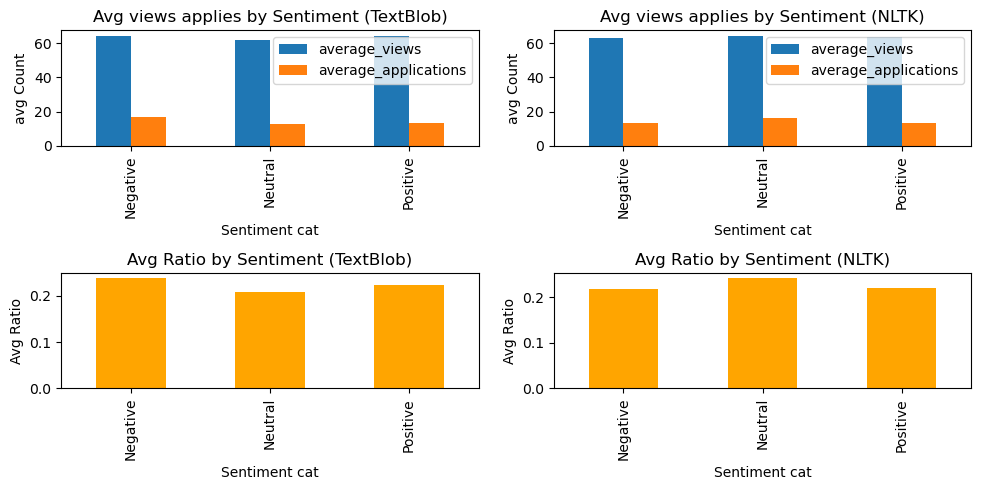

In [36]:
##Vizualization
textblob_df = sentiment_analysis_results_textblob.set_index('sentiment_category_textblob')
textblob_df['avg_applies_to_views_ratio'] = sentiment_analysis_results_textblob_ratio.set_index('sentiment_category_textblob')
nltk_df = sentiment_analysis_results_nltk.set_index('sentiment_category_nltk')
nltk_df['avg_applies_to_views_ratio'] = sentiment_analysis_results_nltk_ratio.set_index('sentiment_category_nltk')

avg_data = [textblob_df, nltk_df]
titles = ['TextBlob', 'NLTK']
fig, axes = plt.subplots(2, 2, figsize=(10, 5))  # 2 rows, 2 columns

for i, df in enumerate(avg_data):
    df[['average_views', 'average_applications']].plot(kind='bar', ax=axes[0, i])
    axes[0, i].set_title(f'Avg views applies by Sentiment ({titles[i]})')
    axes[0, i].set_ylabel('avg Count')
    axes[0, i].set_xlabel('Sentiment cat')

    if 'avg_applies_to_views_ratio' in df.columns:
        df['avg_applies_to_views_ratio'].plot(kind='bar', ax=axes[1, i], color='orange')
        axes[1, i].set_title(f'Avg Ratio by Sentiment ({titles[i]})')
        axes[1, i].set_ylabel('Avg Ratio')
        axes[1, i].set_xlabel('Sentiment cat')
plt.tight_layout()
plt.show()

In [37]:
notebook_end_time = time.time()
total_runtime = notebook_end_time - notebook_start_time
print(f"Total runtime of the notebook: {total_runtime:.2f} seconds")
print(f"Runtime of analyze_sentiment_textblob: {time_method_analyze_sentiment_textblob:.2f} seconds")
print(f"Runtime of analyze_sentiment_nltk: {time_method_analyze_sentiment_nltk:.2f} seconds")

Total runtime of the notebook: 818.93 seconds
Runtime of analyze_sentiment_textblob: 167.05 seconds
Runtime of analyze_sentiment_nltk: 640.49 seconds
